In [26]:
# cartpole 버티기
# Q-learning : (off-policy TD control) 방식으로 카트폴 환경을 학습하기
# MDP(Markov Decision Process) 기반의 강화학습 알고리즘을 사용
# MDP의 5가지 환경 구성요소
# S (State ): 에이전트가 놓일 수 있는 모든 가능한 상황
# A (Action): 에이전트가 각 상태에서 할 수 있는 모든 가능한 동작
# R (Reward)): 에이전트가 상태 s에서 행동 a를 취해 새로운 상태 $s'$에 도달했을 때 받는 보상
# P (Transition Probability): 에이전트가 상태 s에서 행동 a를 취했을 때, 다음 상태 $s'$로 이동할 확률
# π(Policy)): 어떤 상태에서 어떤 행동을 할지를 결정

!pip install gymnasium[classic-control]




In [27]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [28]:
from logging import raiseExceptions
# 환경 설정
env = gym.make('CartPole-v1') # 카트에 막대 (pole)를 수직으로 세운 채 좌우로 움직여 균형을 유지하는 환경을 제공
print(env.observation_space) # 관측 공간
# 카트 위치 , 카트 속도 , 막대 기울기, 막대 각 속도
obs_space_low = np.array([-2.4, -3.0, -0.5, -2.0])
obs_space_high = np.array([2.4, 3.0, 0.5, 2.0])

# 상태 공간 이산화 수준 설정. Q-table은 연속적인 상태를 다를 수 없으므로 구간으로 나눠줘야함
state_bins = [6, 12, 6, 12] # 카트폴의 4가지 관측값에 대해 4가지 이산화 수준을 순서대로 적용해야 하므로, 순서가 보장되는 리스트나 튜플을 사용

q_table = np.zeros(state_bins + [env.action_space.n])


print(q_table.shape)

# 상태 이산화 처리 함수
def discretize_state(state):
    ratios = (state - obs_space_low) / (obs_space_high - obs_space_low)
    # ex) (0-(-2.4))/(2.4--(-2.4)) =
    print('ratios :' , ratios)
    discrete = (ratios * state_bins).astype(int) # 구간이 선택됨
    print('discrete :' , discrete)

    return tuple(np.clip(discrete, 0, np.array(state_bins) -1 )) # 원본 배열, 허용 최소값, 허용 최대값

# discretize_state 결과실험
"""
ex_state = np.array([1.0, 0.5, 0.1, -1.0])
dis_index = discretize_state(ex_state)
print('Q-table 인덱스 :', dis_index)
"""
# Q-learning의 하이퍼파라메터 설정
alpha = 0.1 # Q-테이블 값을 얼마나 빠르게 업데이트할지 결정. 값이 클수록 최근 학습 결과에 더 큰 비중
gammer = 0.99 # 미래의 보상을 얼마나 중요하게 생각할지 결정
epsilon = 1.0 #초기에 1.0으로 설정하여 에이전트가 무작위로 행동하며 탐험을 많이 하도록
epsilon_decay =0.99   # 에피소드가 진행될수록 엡실론 값을 줄여 탐험을 줄이고 학습된 행동을 활용
esilon_min =0.05      # 엡실론이 너무 작아지지 않도록 최솟값을 설정
episodes = 2000
reward_list=[]  # 각 에피소드에서 받은 총 보상
trajectories = []  # 궤적 위치 저장 - 애니메이션 시각화용
best_reward = 0 # 최고의 총 보상 저장

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
(6, 12, 6, 12, 2)


In [29]:
for ep in range(episodes):
  obs, _ =env.reset() # 새로운 에피소드가 시작
  # print(obs)  # [0.00377875 0.00890558 0.00751937 0.04087704]
              # 카트위치, 카트속도, 막대각도, 막대각속도
  state = discretize_state(obs) # 이산화된 상태
  # print(state)  # discrete : [2 5 2 5]
  total_reward = 0 # 하나의 에피소드에서 받는 보상 누적값 초기화
  trajectory = []


  for step in range(200): #하나의 에피소드는 최대 200 스텝까지 실행
    # 행동 선택(탐욕적 행동) -> 환경에 행동 전달 -> 새로운 상태, 보상, 종료여부 반환 -> Q-table 갱신
    # 행동 (탐험/활용) 구현
    if np.random.rand() < epsilon:
      action = env.action_space.sample() # 무작위 행동(exploration)
    else:
      # value state function 사용
      # 현재 가치에서 가장 높은 Q값을 갖는 행동 선택 (a = argmax(Q(s,a)))
      action = np.argmax(q_table[state]) #활용 (Exploitation)
    # print(action) # 0 1 ...
    next_obs, reward, terminated, truncated, _ = env.step(action) # 환경에 행동 적용
    done = terminated or truncated
    next_state = discretize_state(next_obs)
    best_next_q = np.max(q_table[next_state]) # 미래 가치 계산 <다음 상태에서의 최대 Q값>
    # 탐험, 활용 - > 행동 선택, 수행 -> 다음 상태 / 보상 / 종료 정보 획득 -> 상태 이산화 -> 다음 상태에서 가능한 최대 Q값 계산 (미래가치)
    # print(best_next_q)

    # Q - table 갱신 : 현재 상태에서 어떤 행동을 한 후 즉시 보상 또는 다음 상태 기대 보상도 크다면 현재 Q값을 해당 방향으로 조금 끌어 올림
    q_table[state+(action,)] += alpha * (reward + gammer * best_next_q - q_table[state+(action,)]) # (action , )튜플

    # 에이전트가 한 스텝을 마친 후, 다음 스텝 준비를 위한 상태 갱신 및 기록하기
    state = next_state
    obs = next_obs
    total_reward += reward
    trajectory.append(obs.copy())
    if done:
      break   # 에피소드 종료

  reward_list.append(total_reward)

  if total_reward > best_reward:
    best_reward = total_reward
    print(f'Episode {ep} : Reward improved to {total_reward}')



  if ep % 10 == 0:
    trajectories.append(trajectory) # 애니메이션으로 보려고 함

  # epsilon이 감소 - 학습이 진행됨에 따라 무작위 행동을 줄이고, 점점 더 최적 정책에 집중하기위한 전략
  if epsilon > esilon_min:
    epsilon *= epsilon_decay

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
ratios : [0.5179647  0.53232488 0.43709101 0.39184581]
discrete : [3 6 2 4]
ratios : [0.51877282 0.49996197 0.42843867 0.45989755]
discrete : [3 5 2 5]
ratios : [0.51877187 0.53264024 0.42523048 0.38130436]
discrete : [3 6 2 4]
ratios : [0.51958788 0.50030843 0.41573483 0.44835725]
discrete : [3 6 2 5]
ratios : [0.51959559 0.53301168 0.41160341 0.36884984]
discrete : [3 6 2 4]
ratios : [0.52042088 0.50071601 0.40111139 0.4347427 ]
discrete : [3 6 2 5]
ratios : [0.52043878 0.53344673 0.39589081 0.3542019 ]
discrete : [3 6 2 4]
ratios : [0.52127495 0.5011932  0.38422696 0.4187412 ]
discrete : [3 6 2 5]
ratios : [0.52130478 0.53395381 0.37772626 0.33703294]
discrete : [3 6 2 4]
ratios : [0.52215363 0.50174947 0.36468889 0.39998697]
discrete : [3 6 2 4]
ratios : [0.52219736 0.46958795 0.35668784 0.46177389]
discrete : [3 5 2 5]
ratios : [0.52143706 0.50239665 0.35362977 0.37821367]
discrete : [3 6 2 4]
ratios : [0.52149698 0.47026559 0.34388685 0.4390156

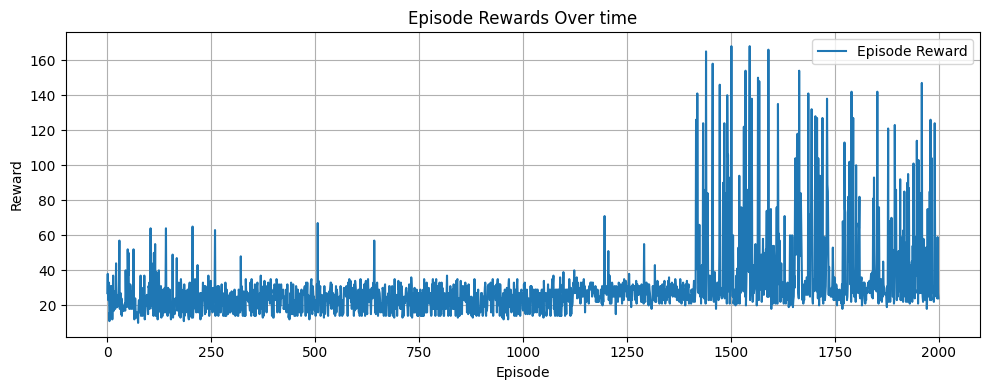

In [30]:
# 학습 곡선 보상 시각화
plt.figure(figsize=(10, 4))
plt.plot(reward_list, label='Episode Reward')
plt.title('Episode Rewards Over time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# @title
# 애니메이션
flat_states = []  # 여러 에피소드의 궤적을 한줄(flat)로 펼쳐서 저장할 리스트
episode_labels = []
episode_numbers = list(range(0, episodes, 10))
print(episode_numbers)

for i, traj in enumerate(trajectories):
  # print(len(traj))
  # print(traj)
  flat_states.extend(traj)
  episode_labels.extend([episode_numbers[i]] * len(traj))
# print(episode_labels)

frame_count = len(flat_states) # 애니메이션에 사용될 총 프레임 수
print(frame_count)

fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-0.5, 1.5)
ax.set_title('Cart simulation')
ax.set_xlabel('Cart position')
ax.set_ylabel('Pole height')
ax.grid(True)

cart_width = 0.4
cart_height = 0.2
cart_y = 0.0
cart_rect = Rectangle((0, 0), cart_width, cart_height, color='black')
ax.add_patch(cart_rect)

# pole 그리기 - line 2d
pole_len = 1.0
line_list = ax.plot([],[], 'r-', lw=4)
pole_line = line_list[0]

episode_text = ax.text(0.05, 1.4, '', transform=ax.transData, color='blue')
print()

def update(frame):
  x = flat_states[frame][0]
  print('x:', x)
  theta = flat_states[frame][2] # 막대 각도
  ep_num = episode_labels[frame]
  cart_rect.set_xy((x - cart_width / 2, cart_y))
  # pole 끝 좌표 계산
  x_start = x
  y_start = cart_y + cart_height
  x_end = x + pole_len * np.sin(theta)
  y_end = cart_y + pole_len * np.cos(theta)
  pole_line.set_data([x_start, x_end], [y_start, y_end])
  episode_text.set_text(f'Episode: {ep_num}')
  return cart_rect, pole_line, episode_text


ani = FuncAnimation(fig, update, frames=frame_count, interval=50, repeat=False)
plt.close(fig)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.